### 引入库
Week3的project中新增的库有：
+ sklearn:用于机器学习、数据处理的库
+ testCases:project给出的测试示例
+ planar_utils:提供例如绘制决策边界、导入平面数据等功能

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary,sigmoid,load_planar_dataset,load_extra_datasets

np.random.seed(1)

### 加载数据

In [2]:
X,Y = load_planar_dataset()

利用matplotlib对二维平面数据 绘制散点图
numpy中的squeeze函数的功能：删除向量中的单维度。即Y原来是(1,m)行向量，调用squeeze后变化为(,m)这样rank=1的向量。
目的是前者可能造成调用matplotlib模块绘制函数时出错或不显示的情况。

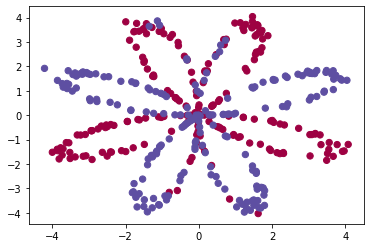

In [3]:
plt.scatter(X[0,:],X[1,:],c=np.squeeze(Y),s=40,cmap=plt.cm.Spectral)

In [4]:
# 检查原始数据维度
print("X dimension:"+str(X.shape))
print("Y dimension:"+str(Y.shape))


X dimension:(2, 400)
Y dimension:(1, 400)


### 利用Logistic Regression进行二分类

In [5]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,Y.T)

D:\Tools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Accuracy of Logistic Regression:0.47


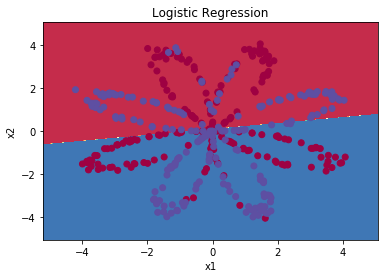

In [6]:
# plot decision boundary
plot_decision_boundary(lambda x:clf.predict(x),X,np.squeeze(Y))
plt.title("Logistic Regression")
# predict 
LR_predictions = clf.predict(X.T)
# Accuracy
LR_acc = float((np.dot(Y,LR_predictions)+np.dot(1-Y,1-LR_predictions))/Y.shape[1])
print("Accuracy of Logistic Regression:"+str(LR_acc))

### 确定NN的结构

In [7]:
def layer_sizes(X,Y):
    """
    返回参数：
        n_x:输入层的单元数
        n_h:隐藏层的单元数
        n_y:输出层的单元数
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return n_x,n_h,n_y

利用testCase中的数据进行测试：

In [8]:
print("======================Test Layer Size=================")
X_case,Y_case = layer_sizes_test_case()
n_x,n_h,n_y = layer_sizes(X_case,Y_case)
print("#Input layer cell: "+str(n_x))
print("#Hidden layer cell: "+str(n_h))
print("#Output layer cell: "+str(n_y))

======================Test Layer Size=================
#Input layer cell: 5
#Hidden layer cell: 4
#Output layer cell: 2


### 初始化参数

In [9]:
def init_params(n_x,n_h,n_y):
    """
    返回：
        W1,b1,W2,b2
        其中W1,W2不能全部初始化为0
    """
    np.random.seed(2)
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    params = {
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2
    }
    return params

对参数初始化函数进行测试

In [10]:
print("=========Test init_params==========")
n_x,n_h,n_y = initialize_parameters_test_case()
params = init_params(n_x,n_h,n_y)
print("W1:"+str(params["W1"]))
print("b1:"+str(params["b1"]))
print("W2:"+str(params["W2"]))
print("b2:"+str(params["b2"]))

=========Test init_params==========
W1:[[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1:[[0.]
 [0.]
 [0.]
 [0.]]
W2:[[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2:[[0.]]


### Forward Prop

In [11]:
def forward_propagation(X,params):
    """
    参数：
        params - W1,b1,W2,b2参数
    返回：
        A2:输出值
        cache:Z1,A1,Z2,A2这些bp算法中需要的中间参数
    """
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoid(Z2)
    
    cache={
        "Z1":Z1,
        "A1":A1,
        "Z2":Z2,
        "A2":A2
    }
    return A2,cache

测试Forward Prop

In [12]:
print("======Test forward prop==========")
X_case,params = forward_propagation_test_case()
A2,cache = forward_propagation(X_case,params)
print(np.mean(cache["Z1"]),np.mean(cache["A1"]),np.mean(cache["Z2"]),np.mean(cache["A2"]))


======Test forward prop==========
-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431


### Compute Cost

In [17]:
def compute_cost(A2,Y):
    m = Y.shape[1]
    logprobs = np.multiply(Y,np.log(A2))+np.multiply((1-Y),np.log(1-A2))
    cost = float(-np.sum(logprobs)/m)
    return cost

对计算损失的模块进行测试

In [18]:
print("=========Test Compute Cost==========")
A2,Y_case,params = compute_cost_test_case()
print("cost: "+str(compute_cost(A2,Y_case)))

=========Test Compute Cost==========
cost: 0.6929198937761266


### Back Prop

In [23]:
def backward_propagation(params,cache,X,Y):
    """
    返回参数：
        grads - 包含梯度信息的字典
    """
    m = Y.shape[1]
    W1,W2,b1,b2 = params["W1"],params["W2"],params["b1"],params["b2"]
    Z1,Z2,A1,A2 = cache["Z1"],cache["Z2"],cache["A1"],cache["A2"]
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)/m
    dZ1 = np.multiply(np.dot(W2.T,dZ2),(1-np.power(A1,2)))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m
    grads = {
        "dW1":dW1,
        "db1":db1,
        "dW2":dW2,
        "db2":db2
    }
    return grads

对back propagation后向传播模块进行测试

In [24]:
print("===========Test Backward Propagation========")
params,cache,X_case,Y_case = backward_propagation_test_case()
grads = backward_propagation(params,cache,X_case,Y_case)
print("dW1: "+str(grads["dW1"]))
print("db1: "+str(grads["db1"]))
print("dW2: "+str(grads["dW2"]))
print("db2: "+str(grads["db2"]))


===========Test Backward Propagation========
dW1: [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1: [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2: [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2: [[0.06589489]]


### Gradient Descent

In [25]:
def update_params(params,grads,learning_rate=1.2):
    W1,W2,b1,b2 = params["W1"],params["W2"],params["b1"],params["b2"]
    dW1,dW2,db1,db2 = grads["dW1"],grads["dW2"],grads["db1"],grads["db2"]
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2
    params = {
        "W1":W1,
        "W2":W2,
        "b1":b1,
        "b2":b2
    }
    return params

对梯度下降模块进行测试

In [26]:
print("==========Test update_params=========")
params,grads = update_parameters_test_case()
params = update_params(params,grads)
print("W1 = "+str(params["W1"]))
print("b1 = "+str(params["b1"]))
print("W2 = "+str(params["W2"]))
print("b2 = "+str(params["b2"]))


==========Test update_params=========
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


### 整合

In [34]:
def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    np.random.seed(3)
    n_x,temp,n_y = layer_sizes(X,Y)
    params = init_params(n_x,n_h,n_y)
    W1,W2,b1,b2 = params["W1"],params["W2"],params["b1"],params["b2"]
    for i in range(num_iterations):
        A2,cache = forward_propagation(X,params)
        cost = compute_cost(A2,Y)
        grads = backward_propagation(params,cache,X,Y)
        params = update_params(params,grads,learning_rate=1.2)
        
        if print_cost:
            if i%1000==0:
                print("Cost of Loop "+str(i)+":"+str(cost))
    return params

测试nn_models

In [35]:
print("======test nn_models=======")
X_case,Y_case = nn_model_test_case()
params = nn_model(X_case,Y_case,4,num_iterations=10000,print_cost=False)
print("W1 = "+str(params["W1"]))
print("b1 = "+str(params["b1"]))
print("W2 = "+str(params["W2"]))
print("b2 = "+str(params["b2"]))

======test nn_models=======


D:\Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


W1 = [[-4.18494502  5.33220306]
 [-7.52989352  1.24306198]
 [-4.19295477  5.32631754]
 [ 7.52983748 -1.24309404]]
b1 = [[ 2.32926814]
 [ 3.79459053]
 [ 2.3300254 ]
 [-3.79468789]]
W2 = [[-6033.83672183 -6008.12981297 -6033.10095335  6008.0663689 ]]
b2 = [[-52.666077]]


### predict

In [36]:
def predict(params,X):
    A2,cache = forward_propagation(X,params)
    predictions = np.round(A2)
    return predictions

测试predict函数

In [37]:
print("========Test predict========")
params,X_case = predict_test_case()
predictions = predict(params,X_case)
print("Average of predictions : "+str(np.mean(predictions)))

========Test predict========
Average of predictions : 0.6666666666666666


### 将模型用于正式数据

Cost of Loop 0:0.6930480201239823
Cost of Loop 1000:0.28808329356901846
Cost of Loop 2000:0.25438549407324546
Cost of Loop 3000:0.23386415038952202
Cost of Loop 4000:0.2267924874485401
Cost of Loop 5000:0.2226442754929902
Cost of Loop 6000:0.21973140404281322
Cost of Loop 7000:0.21750365405131297
Cost of Loop 8000:0.219528426834015
Cost of Loop 9000:0.21862727554078742
准确率: 90%


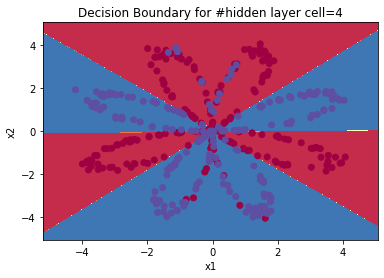

In [39]:
params = nn_model(X,Y,n_h=4,num_iterations=10000,print_cost=True)

# Plot design boundary
plot_decision_boundary(lambda x:predict(params,x.T),X,np.squeeze(Y))
plt.title("Decision Boundary for #hidden layer cell=4")

predictions = predict(params,X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')